In [27]:
import boto3
import duckdb
import polars as pl
import pandas as pd
import numpy as np
import pyarrow
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
s3 = boto3.resource('s3',
  endpoint_url = 'https://7a28e49ec5f4a60c66f216392792ac38.r2.cloudflarestorage.com',
  aws_access_key_id = '1f25ab4babdb705e3f184709dc88c837',
  aws_secret_access_key = '0e853ebdf7872e96cb845f64237c14f1c29131c09565b5a610923526aea06791'
)
bucket = s3.Bucket('busdc-transfers')
keys = []


start = 0


dfs = [] #array of dataframes

for item in bucket.objects.all():
#   print(' - ', item.key)
  keys.append(item.key)
end = len(keys) 
for i in range(start,end):
#   print(' - ', item.key)
  if keys[i].endswith('.parquet'):
    link =  "SELECT block_number, value, timestamp FROM read_parquet('https://busdc-transfers.sqd-datasets.io/"+keys[i]
    link+="');"

    dfi = duckdb.sql(link).pl().with_columns(amount=pl.col.value.str.to_decimal().cast(pl.Float64()) / 1e18, time = pl.col.timestamp//1000).select("block_number", "amount",timestamp=pl.from_epoch("time", time_unit="s"),)
   
    dfs.append(dfi)


df = pl.concat(dfs) 

print(df)
#results



shape: (43_875_942, 3)
┌──────────────┬─────────────┬─────────────────────┐
│ block_number ┆ amount      ┆ timestamp           │
│ ---          ┆ ---         ┆ ---                 │
│ i64          ┆ f64         ┆ datetime[μs]        │
╞══════════════╪═════════════╪═════════════════════╡
│ 1477489      ┆ 1e7         ┆ 2020-10-19 10:44:09 │
│ 1477526      ┆ 5e6         ┆ 2020-10-19 10:46:00 │
│ 1477530      ┆ 5e6         ┆ 2020-10-19 10:46:12 │
│ 1503652      ┆ 3e6         ┆ 2020-10-20 08:32:18 │
│ …            ┆ …           ┆ …                   │
│ 32255024     ┆ 0.38897     ┆ 2023-10-02 15:09:24 │
│ 32255025     ┆ 1445.527956 ┆ 2023-10-02 15:09:27 │
│ 32255027     ┆ 907.357248  ┆ 2023-10-02 15:09:33 │
│ 32255027     ┆ 400.909218  ┆ 2023-10-02 15:09:33 │
└──────────────┴─────────────┴─────────────────────┘


In [28]:
interval = "1d"
time_span = df.select(
    min=pl.col.timestamp.first(),
    max=pl.col.timestamp.last(),
).with_columns(
    pl.all().dt.truncate(interval).suffix("_t"),
    span=pl.col.max - pl.col.min,
)
time_range = pl.datetime_range(
    time_span[0, "min_t"], time_span[0, "max_t"], interval, eager=True
)
time_span.select("min", "max", "span")
print(time_span)

shape: (1, 5)
┌──────────────┬──────────────┬─────────────────────┬─────────────────────┬──────────────────┐
│ min          ┆ max          ┆ min_t               ┆ max_t               ┆ span             │
│ ---          ┆ ---          ┆ ---                 ┆ ---                 ┆ ---              │
│ datetime[μs] ┆ datetime[μs] ┆ datetime[μs]        ┆ datetime[μs]        ┆ duration[μs]     │
╞══════════════╪══════════════╪═════════════════════╪═════════════════════╪══════════════════╡
│ 2020-10-19   ┆ 2023-10-02   ┆ 2020-10-19 00:00:00 ┆ 2023-10-02 00:00:00 ┆ 1078d 4h 25m 24s │
│ 10:44:09     ┆ 15:09:33     ┆                     ┆                     ┆                  │
└──────────────┴──────────────┴─────────────────────┴─────────────────────┴──────────────────┘


In [29]:
amount_span = df.filter(pl.col.amount > 0).select(
    min=pl.col.amount.min(),
    max=pl.col.amount.max(),
    min_log=pl.col.amount.min().log(10),
    max_log=pl.col.amount.max().log(10),
)
amount_span

min,max,min_log,max_log
f64,f64,f64,f64
1.0000e-18,7e8,-18.0,8.845098


In [30]:
golden = (1 + 5**0.5) / 2
aspect = golden
width = len(time_range)
height = int(width / aspect)
buckets = np.logspace(-2, 6, height)
width, height

(1079, 666)

In [33]:
transfer_stats = (
    df.with_columns(
        bucket=pl.col.amount.cut(buckets, include_breaks=True),
    )
    .sort("timestamp")
    .group_by_dynamic("timestamp", every=interval)
    .agg(
        txs_per_bucket=pl.col.bucket.struct.field("brk").value_counts(),
    )
    .explode("txs_per_bucket")
    .unnest("txs_per_bucket")
    .rename({"brk": "bucket", "counts": "num_txs"})
    .with_columns(
        bucket=pl.when(pl.col.bucket == float("inf"))
        .then(buckets[-1])
        .otherwise(pl.col.bucket),
        num_txs=pl.when(pl.col.bucket == buckets[0]).then(0).otherwise(pl.col.num_txs),
    )
)
print(len(transfer_stats), "datapoints")

627832 datapoints


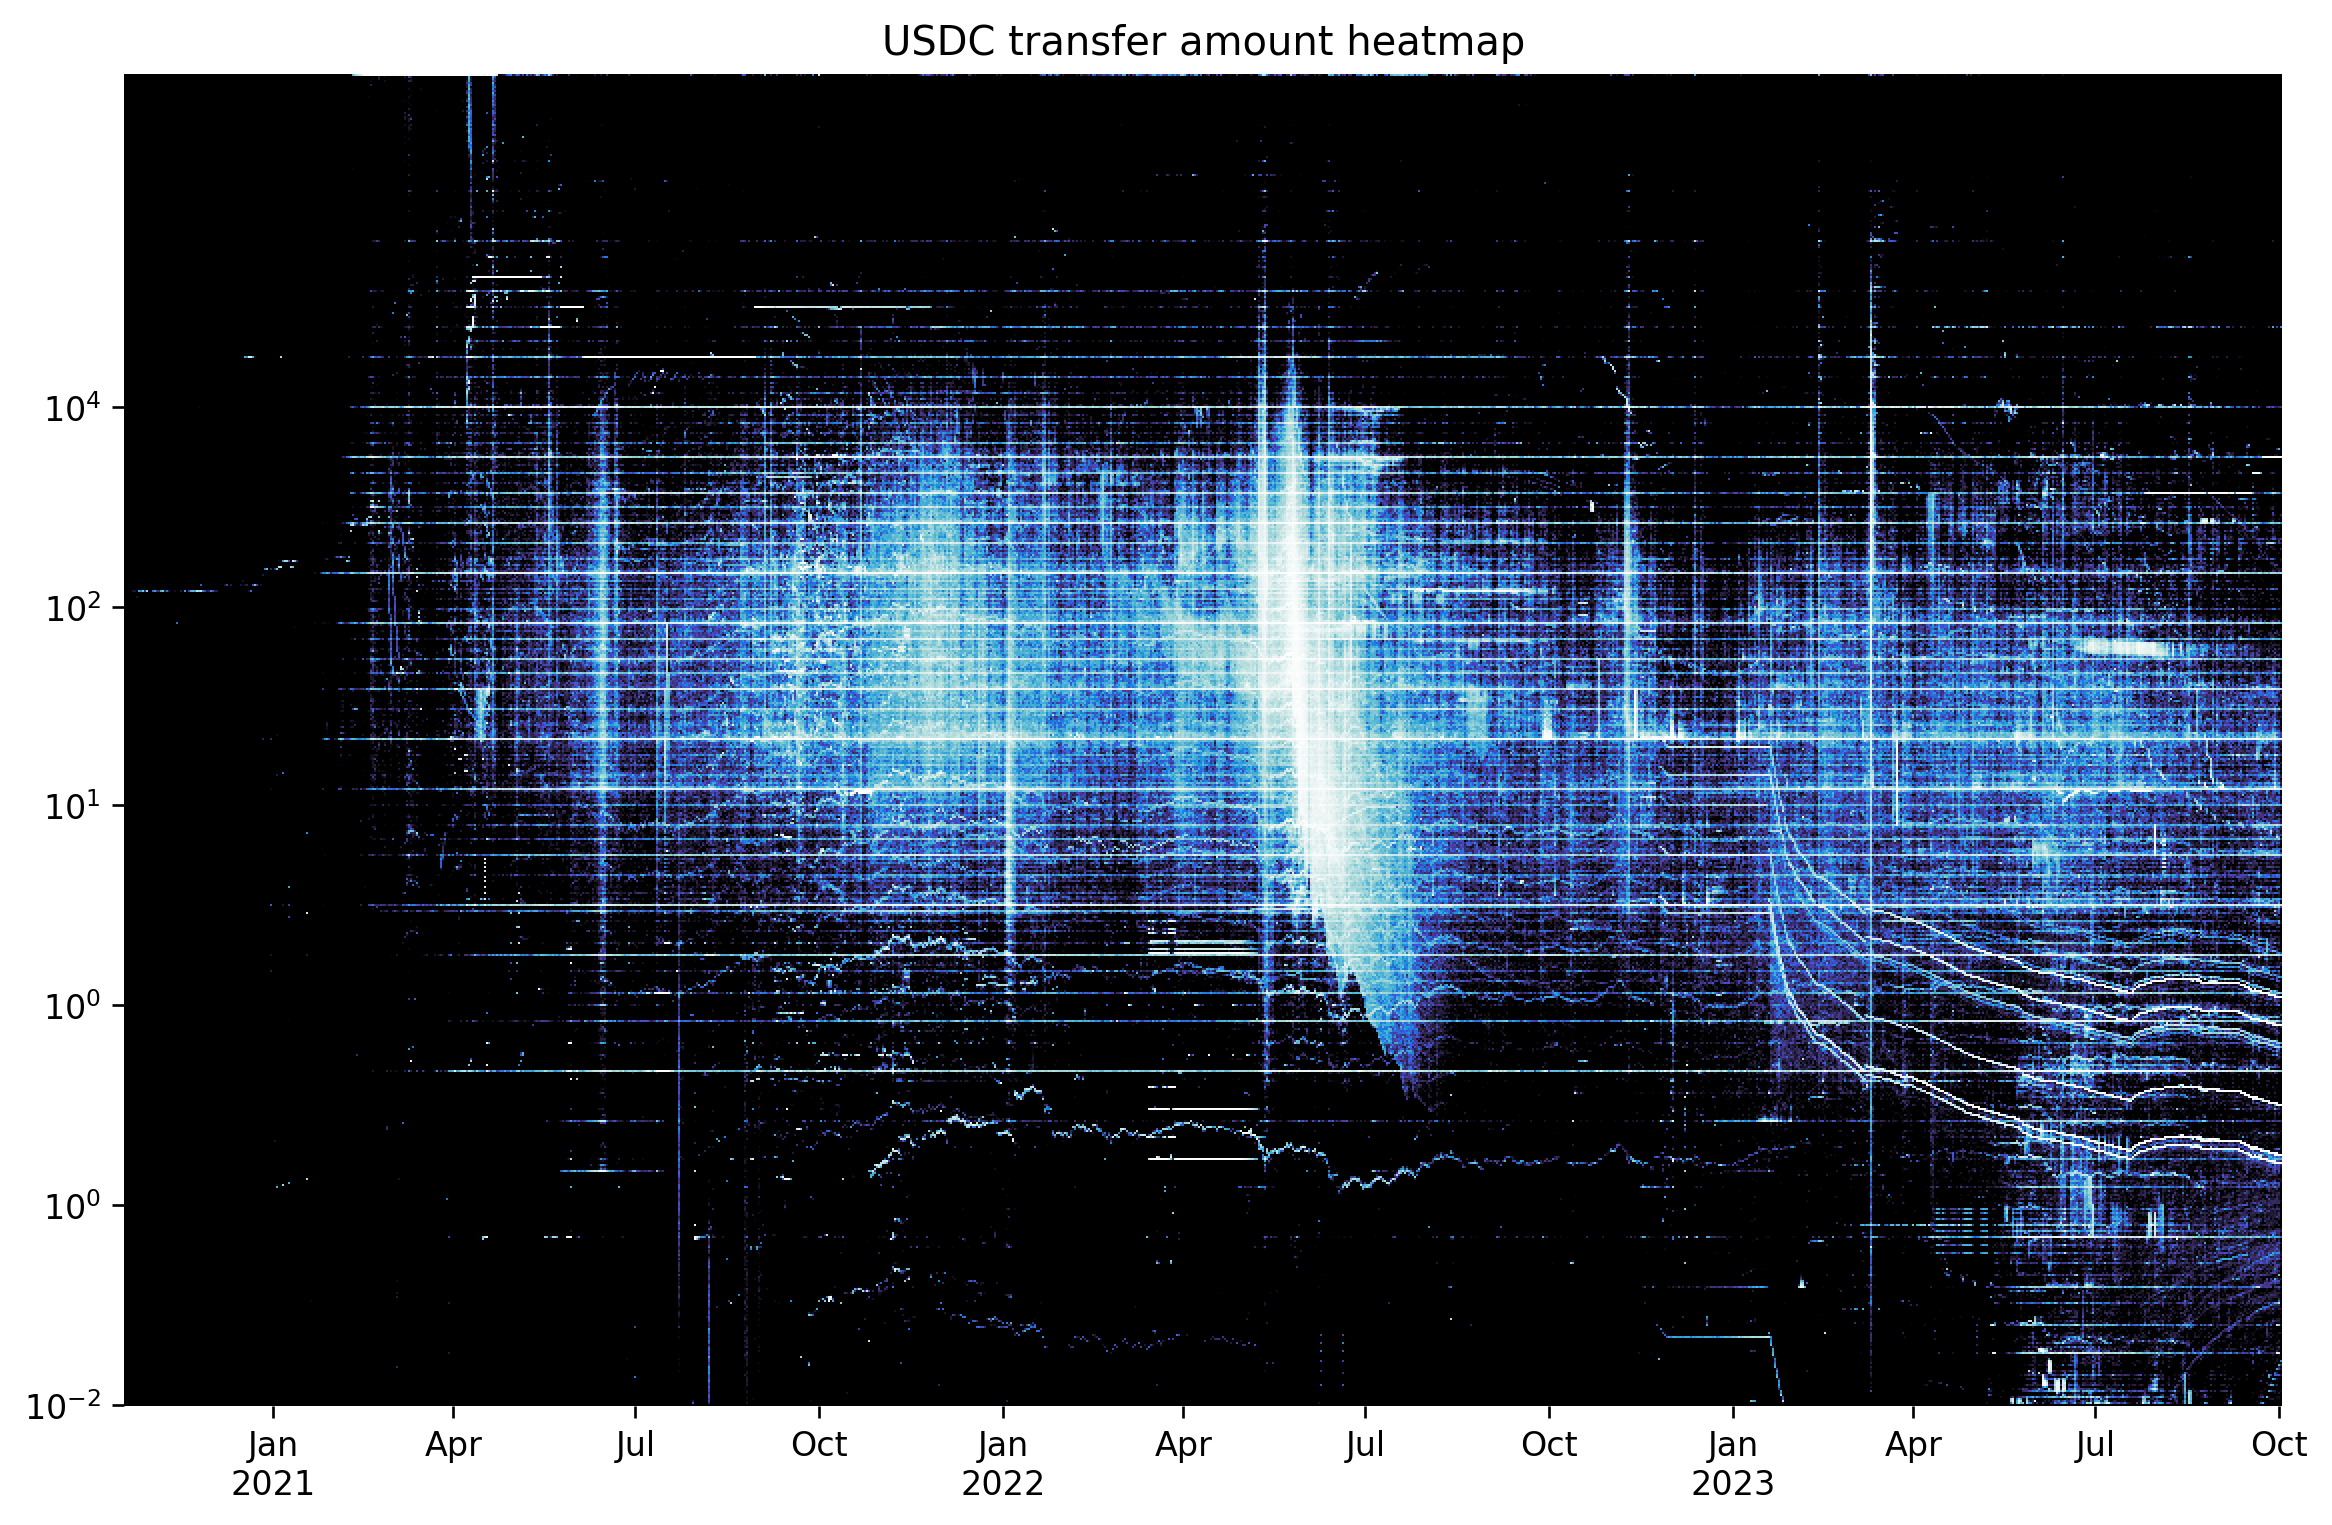

In [34]:
from skimage.exposure import equalize_hist
import cmasher
from IPython import display
%config InlineBackend.figure_format = 'retina'

# convert timestamps to x coordinates and buckets to y coordinates
date_to_x = (
    pl.DataFrame({"timestamp": time_range})
    .with_row_count()
    .rename({"row_nr": "x"})
)
bucket_to_y = (
    pl.DataFrame({"bucket": buckets})
    .with_row_count()
    .rename({"row_nr": "y"})
)
source = (
    transfer_stats
    .join(date_to_x, on="timestamp")
    .join(bucket_to_y, on="bucket")
)
x = source["x"].to_numpy()
y = source["y"].to_numpy()
w = source["num_txs"].to_numpy()
H, xe, ye = np.histogram2d(x, y, weights=w, bins=[width, height])
# match the figure size with the image size
dpi = 120
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
fig.add_axes((0, 0, 1, 1), frame_on=False)
# note: histogram2d flips the cartesian coordinates
im = plt.imshow(equalize_hist(H.T), origin="lower", cmap=cmasher.freeze)
ax = plt.gca()
# y axis ticks
y_ticks = np.logspace(-2, 4, 6)
y_indexes = [np.where(buckets >= t)[0][0] for t in y_ticks]
ax.set_yticks(y_indexes, [f'$10^{{{int(np.log10(n))}}}$' for n in y_ticks])
# x axis ticks
dts = date_to_x.group_by_dynamic('timestamp', every='1q').agg(pl.col.x.first()).tail(-1)
x_ticks = dts['timestamp'].cast(pl.Date).to_list()
ax.set_xticks(dts['x'].to_numpy(), [f'{x.strftime("%b")}' + (f'\n{x.strftime("%Y")}' if x.month == 1 else "") for x in x_ticks])
plt.title('USDC transfer amount heatmap')
# this method works both for `show` and `savefig`
plt.savefig('heatmap-matplotlib.png', bbox_inches='tight')
plt.show()

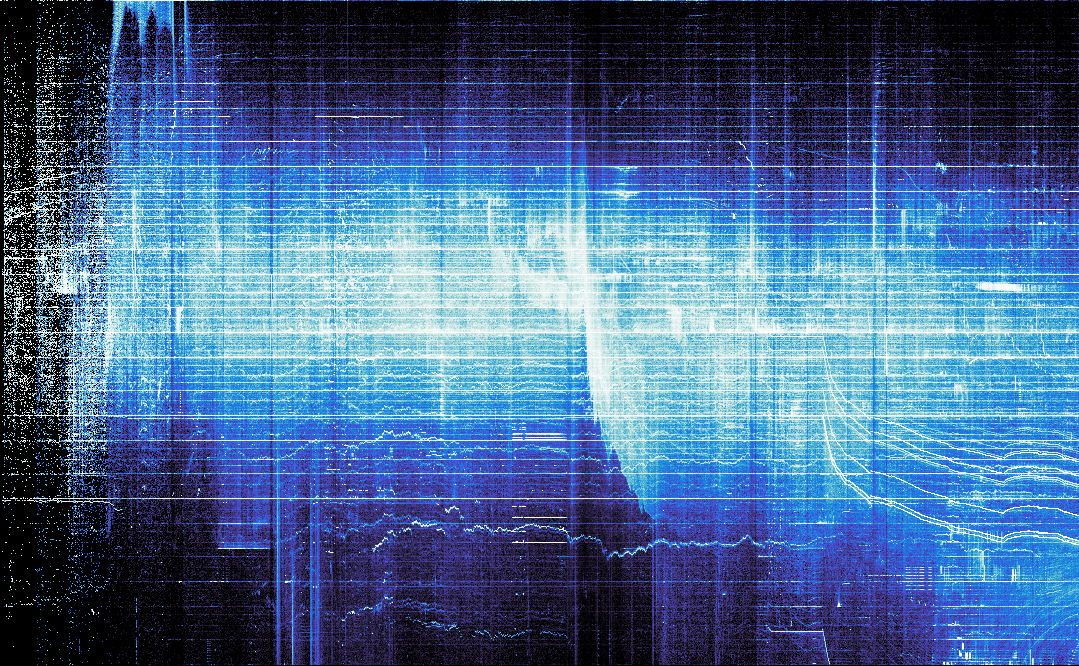

In [35]:
import datashader as ds
from datashader import transfer_functions as tf

df = transfer_stats.with_columns(
    pl.col.timestamp.cast(pl.Float64),
    normalized=pl.col.num_txs / pl.col.num_txs.sum().over("timestamp"),
).to_pandas()

canvas = ds.Canvas(plot_width=width, plot_height=height, y_axis_type="log")
points = canvas.points(df, "timestamp", "bucket", agg=ds.sum("normalized")).fillna(0)
heatmap = tf.shade(points, cmap=cmasher.freeze)
heatmap.to_pil().save("heatmap.png")
display.Image("heatmap.png")